In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# News Classification with Naive Bayes

we are going to perform the clasification of news dataset using the Naive Bayes Approach. For this project we have used the dataset from Kaggle https://www.kaggle.com/datasets/rmisra/news-category-dataset/. 

Before we get into the actual problem, we will broefly describe concept of  Bayes Theorem

### Bayes Theorem 

It describes the probability of an event, based on prior knowledge of conditions that might be related to the event. For example, if the risk of developing health problems is known to increase with age, Bayes' theorem allows the risk to an individual of a known age to be assessed more accurately (by conditioning it on their age) than simply assuming that the individual is typical of the population as a whole

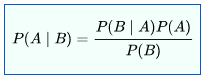

the result P(A|B) is referred to as the posterior probability and P(A) is referred to as the prior probability.

P(A|B): Posterior probability.
P(A): Prior probability.


### Importing data 

we will import the data using Pandas library. JSON is plain text, but has the format of an object, and is well known in the world of programming, including Pandas library

Function : `read_json()`

WE will visualise the first 10 lines of the observed dataframe, inorder to understand the present data structure

In [3]:
df = pd.read_json('data.json', lines = True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


### Exploratory Data Analysis

Lets Analyze the following features of the data 
- How many Datapoints are there.
- What are the each input features
- How many categories are there
- How many datapoints are there in each category

#### Total number of Data Points


In [5]:
print("Size of Data : " , df.shape[0])
df.describe()

Size of Data :  200853


,category,headline,authors,link,short_description,date
count,200853,200853,200853,200853,200853,200853
unique,41,199344,27993,200812,178353,2309
top,POLITICS,Sunday Roundup,,https://www.huffingtonpost.comhttp://www.polit...,,2013-01-17 00:00:00
freq,32739,90,36620,2,19712,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2018-05-26 00:00:00


#### Total Number of Categories
We will get the count of number of datapoints available for each of the categories. 

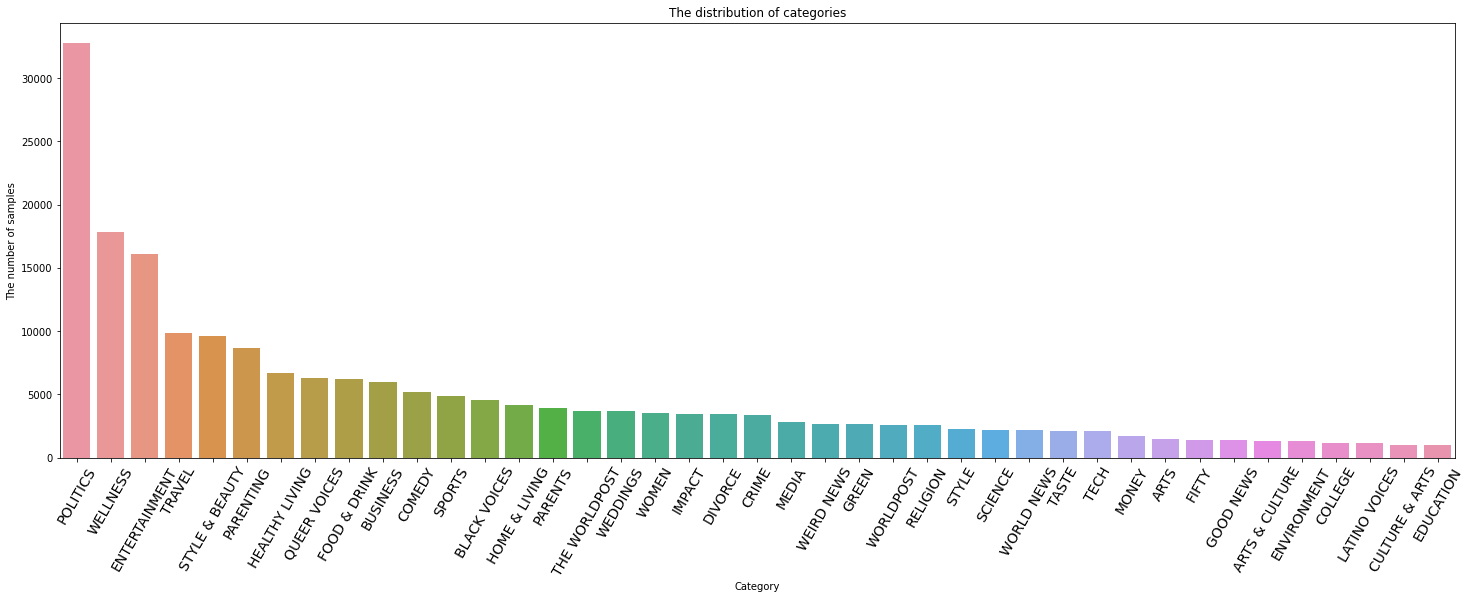

In [6]:
count = df['category'].value_counts()
plt.figure(figsize=(25,8))
sns.barplot(x=count.index,y=count.values)
plt.title("The distribution of categories")
plt.xlabel("Category")
plt.ylabel("The number of samples")

plt.xticks(rotation=60,fontsize = 14)
plt.show()

## Data Cleanup

Cleanup all the rows which has incomplete values in the dataframe and reduce the size of the data

In [8]:
for i in df.columns:
    df[i].replace('',np.nan,inplace = True)
df.dropna( inplace=True)
print("Updated Values : " , df.shape)
count = df['category'].value_counts()

Updated Values :  (148983, 6)


## Test Train Datasplit

Now we will split the data into the following
- Testing - 60%
- Development  - 20%
- Testing - 20%

After performing this, we need to perform a 5 fold cross validation with Respect to the given dataset. As of now, we will perform a 5 fold cross valdation with Testing and development dataset alone. 

In [9]:

train, Test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.8*len(df))])

## now Split the Test data into test and development data for Cross Validation

train_kfold, dev_kfold = \
              np.split(train.sample(frac=1, random_state=42), 
                       [int(.8*len(train))])

print(" Testing Dataset : " , Test.shape[0])
print(" Training Dataset : " , train_kfold.shape[0])
print(" Dev Dataset : " , dev_kfold.shape[0])

 Testing Dataset :  29797
 Training Dataset :  95348
 Dev Dataset :  23838


### Cross Validation
Cross-validation is a resampling method that uses different portions of the data to test and train a model on different iterations. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice

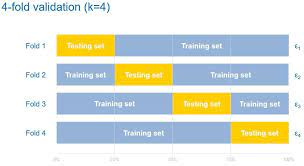

## Get the Frequency count of all the words

we will now obtain the frequency of all the words in the given headlines and their description. This will be used to calculate all the probabilities of the given system

### Compute Prior Probability

First, We will compute the prior probability of all the classes available . this will compute the probability of occurence of each class in the given system 

The prior probability is the general probability of occurence of the class <br />
`P(Category)`  = $\frac{Num Of Occurences of category}{total data points}$  `   

In [11]:
##  Computing prior probbiltiy
count = train_kfold['category'].value_counts()
priorProbability = {key: value for key, value in count.items()}
for k,v in count.items():
    priorProbability[k] = v/train_kfold.shape[0]

### Get all the count of words 

WE will now get all the count of words in the Headlines and the descriptions


In [13]:
wordList = []
import re

mainDictionary = {}
for category,value in zip(train_kfold.category,train_kfold.headline):
    values = value.split(' ')
    values = list(map(str.lower,values))
    
    for k in values:
        ## Existing Values
        k = str(k)
        k_new = re.sub('[^a-zA-Z0-9 \n\.]', '', k)
        if( k_new not in mainDictionary ):
            mainDictionary[k_new] = {key: 0 for key, value in count.items()}
        
        mainDictionary[k_new][category] +=1;
freqWords = pd.DataFrame(mainDictionary)


Text(0.5, 1.0, 'Histogram of TOp words in each category')

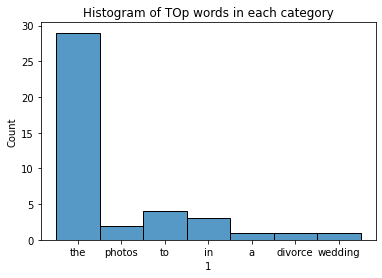

In [14]:
# avoidList = ['the', 'to', 'a','of','in','and','for','is','on','your','with','my','you','at','as','this','why','how','what','who','i']
avoidList = []
Location = freqWords.loc[:,~freqWords.columns.isin(avoidList)].idxmax(axis=1).to_list() 
Count    = freqWords.loc[:,~freqWords.columns.isin(avoidList)].max(axis=1).to_list()
category = freqWords.index.to_list()

mostUsedWords = pd.DataFrame([category,Location,Count], index=None)
mostUsedWords = mostUsedWords.transpose()
mostUsedWords

ax = sns.histplot(mostUsedWords[1])
ax.set_title("Histogram of TOp words in each category")

## Elimination of Common words

Here we could observe that the most top word across all the categories was `the`. The reasons why we cannot use this as trainig data without preprocessing are

- The word `the` is very generic word, and we cannot let this word be the top word in every category as this will skew the probability 
- we need to eliminte these generalised words from our prediction such each category can have unique words which reperesent those categories

Upon analysis , we removed all the common words that were available in the code, and plotted the histogram to check for equal 
distribution

the words that were removed are 

```
['the', 'to', 'a','of','in','and','for','is','on','your','with','my','you','at','as','this','why','how','what','who','i']
```


#### Drop the Common words


Now we will remove the most common words from our dataframe in order to ignore them while computing the probabitity matrix


In [16]:
freqWords = freqWords.drop(avoidList,axis=1)
freqWords.head()

,are,you,a,boy,iphone,cases,that,as,cute,purses,...,mechanical,mamahood,stitched,trumpcabinetband,bummer,chomskys,mandera,ringo,through...,angelous
POLITICS,731,369,2457,14,1,8,512,545,2,0,...,0,1,0,0,0,1,0,0,0,0
WELLNESS,312,891,1233,4,1,18,185,95,1,0,...,0,0,0,0,0,0,0,0,0,0
ENTERTAINMENT,253,319,1336,24,1,1,206,226,18,0,...,0,0,0,0,0,0,0,0,0,0
TRAVEL,133,378,949,1,1,0,141,39,0,0,...,0,0,0,0,0,0,0,0,0,0
STYLE & BEAUTY,145,227,698,5,6,6,164,81,16,5,...,0,0,0,0,0,0,0,0,0,0


### Conditional Probability 

Now compute the conditional probability of the given data. i.e compute the probability of the occurance of `word` given its in a category `X`. 

` P( Word | Category ) `

Using this and the `P(Category)`, we should be able to get the posterior probabilities in term of Probability of a category given a word is present `P(Category|Word)`, which will be responsible for the classification of our data. 

In order to compute that, we will obtain the total number of occurences of every word on each class and append it as another column

In [17]:
# freqWords["sum"] = freqWords.sum(axis=1)
ConditionalProb = freqWords.copy(deep=True)

ConditionalProb = ConditionalProb.div(ConditionalProb.sum(axis=1), axis=0)
ConditionalProb.head()

,are,you,a,boy,iphone,cases,that,as,cute,purses,...,mechanical,mamahood,stitched,trumpcabinetband,bummer,chomskys,mandera,ringo,through...,angelous
POLITICS,0.004137,0.002089,0.013907,0.000079,0.000006,0.000045,0.002898,0.003085,0.000011,0.000000,...,0.0,0.000006,0.0,0.0,0.0,0.000006,0.0,0.0,0.0,0.0
WELLNESS,0.004958,0.014158,0.019593,0.000064,0.000016,0.000286,0.002940,0.001510,0.000016,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
ENTERTAINMENT,0.002969,0.003743,0.015676,0.000282,0.000012,0.000012,0.002417,0.002652,0.000211,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
TRAVEL,0.003219,0.009148,0.022967,0.000024,0.000024,0.000000,0.003412,0.000944,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
STYLE & BEAUTY,0.003036,0.004752,0.014613,0.000105,0.000126,0.000126,0.003433,0.001696,0.000335,0.000105,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [18]:
ConditionalProb.sum(axis=1).head()
PREDICTIONLABEL = ConditionalProb.index.to_list()
PREDICTIONLABEL_DICT = dict(zip(PREDICTIONLABEL,list(range(len(PREDICTIONLABEL))) ))

### NVB - Classifier. 

Get all the dev dataset and clean them, to get them ready for classification. 
- Seperate the actul value of the class 
- Seperate the words from the list and remove the most commonly used words




In [20]:
yActual = dev_kfold.category.to_list()

Y_test = []
for line in dev_kfold.headline.to_list():
    lines = line.split(' ')
    values = list(map(str.lower,lines))
    newlist = [];
    for k in values:
        k = str(k);
        k_new = re.sub('[^a-zA-Z0-9 \n\.]', '', k)
        if(k_new not in avoidList):
            newlist.append(k_new)
    
    Y_test.append(newlist)
    

#### Prediction of Likelyhood
Now we will identify the probability of given headline for all the given classes,which will determine which class the given measure belongs to.

In [21]:
Y_pred = []

for data in Y_test:
    probList = []
    for cat in PREDICTIONLABEL:
        probList.append(priorProbability[cat])
    probList = np.array(probList);
    for word in data:
        try:
            probList *= ConditionalProb[word].to_numpy()
        except KeyError:
            probList;
    Y_pred.append(probList)

Y_pred_df = pd.DataFrame(Y_pred)

prevSize = Y_pred_df.shape[0];
print("Actual Size : " , prevSize)
##Remvove the entries with zero probability , to compute accuracy
Y_pred_df["idmax"] = Y_pred_df.idxmax(axis=1)
Y_pred_df["sum"] = Y_pred_df.sum(axis=1)


yPred_num = [];
yActual_num = [];
for i in range(len(yActual)):
#     if(Y_pred_df["sum"][i] > 0):
    yActual_num.append(PREDICTIONLABEL_DICT[yActual[i]] )
    yPred_num.append(Y_pred_df["idmax"][i])

from sklearn.metrics import accuracy_score, f1_score , precision_score

print("Accuracy Score : " , accuracy_score(yActual_num,yPred_num))
print("Precision Score : " , precision_score(yActual_num,yPred_num,average='macro'))
print("F1 Score " , f1_score(yActual_num,yPred_num,average='micro'))

Actual Size :  23838
Accuracy Score :  0.3934893866935146
Precision Score :  0.3629310119324888
F1 Score  0.3934893866935146


In [ ]:
from sklearn.metrics import accuracy_score, f1_score , precision_score
import re
def crossValidationNaiveBayes(train,kfold,PropConst):
    accuracyArray = []
    f1Array = []
    precisionArray = []
    for iterNum in range(kfold):
        print("Performing Cross Validation : " , iterNum)
        train_kfold, dev_kfold = \
                  np.split(train.sample(frac=1, random_state=np.random.randint(0,100)), 
                           [int(.8*len(train))])
        
        count = train_kfold['category'].value_counts()
        priorProbability = {key: value for key, value in count.items()}
        for k,v in count.items():
            priorProbability[k] = v/train_kfold.shape[0];
        
        wordList = []
        

        mainDictionary = {}
        for category,value in zip(train_kfold.category,train_kfold.headline):
            values = value.split(' ')
            values = list(map(str.lower,values))

            for k in values:
                ## Existing Values
                k = str(k)
                k_new = re.sub('[^a-zA-Z0-9 \n\.]', '', k)
                if( k_new not in mainDictionary ):
                    mainDictionary[k_new] = {key: 0 for key, value in count.items()}

                mainDictionary[k_new][category] +=1;
                
        freqWords = pd.DataFrame(mainDictionary)
        avoidList = ['the', 'to', 'a','of','in','and','for','is','on','your','with','my','you','at','as','this','why','how','what','who','i','are','that']
        freqWords = freqWords.drop(avoidList,axis=1)
        ConditionalProb = freqWords.copy(deep=True)
        
        ConditionalProb = ConditionalProb.div(ConditionalProb.sum(axis=1), axis=0)
        
        yActual = dev_kfold.category.to_list()

        Y_test = []
        for line in dev_kfold.headline.to_list():
            lines = line.split(' ')
            values = list(map(str.lower,lines))
            newlist = [];
            for k in values:
                k = str(k);
                k_new = re.sub('[^a-zA-Z0-9 \n\.]', '', k)
                if(k_new not in avoidList):
                    newlist.append(k_new)

            Y_test.append(newlist)
        
        Y_pred = []
        
        for data in Y_test:
            probList = []
            for cat in PREDICTIONLABEL:
                probList.append(priorProbability[cat]*PropConst)
            probList = np.array(probList);
            for word in data:
                try:
                    probList *= ConditionalProb[word].to_numpy()
                except KeyError:
                    probList;
            Y_pred.append(probList)
        
        Y_pred_df = pd.DataFrame(Y_pred)

        prevSize = Y_pred_df.shape[0];
#         print("Actual Size : " , prevSize)
        ##Remvove the entries with zero probability , to compute accuracy
        Y_pred_df["idmax"] = Y_pred_df.idxmax(axis=1)
        Y_pred_df["sum"] = Y_pred_df.sum(axis=1)


        yPred_num = [];
        yActual_num = [];
        for i in range(len(yActual)):
        #     if(Y_pred_df["sum"][i] > 0):
            yActual_num.append(PREDICTIONLABEL_DICT[yActual[i]] )
            yPred_num.append(Y_pred_df["idmax"][i])

        accuracyArray.append(accuracy_score(yActual_num,yPred_num))
#         precisionArray.append(precision_score(yActual_num,yPred_num,average='macro'))
#         f1Array.append( f1_score(yActual_num,yPred_num,average='micro'))
        
        print("     Accuracy  : " , accuracyArray[iterNum])
#         print("     Precision : " , precisionArray[iterNum])
#         print("     F1        : " , f1Array[iterNum])
    
    return accuracyArray
    

In [24]:

accuracyArray= crossValidationNaiveBayes(train,5,10)

Performing Cross Validation :  0
     Accuracy  :  0.3637050088094639
Performing Cross Validation :  1
     Accuracy  :  0.36185921637721286
Performing Cross Validation :  2
     Accuracy  :  0.37259837234667337
Performing Cross Validation :  3
     Accuracy  :  0.3736051682188103
Performing Cross Validation :  4
     Accuracy  :  0.3713818273345079


Text(0.5, 1.0, 'Accuracy across all k fold iterations')

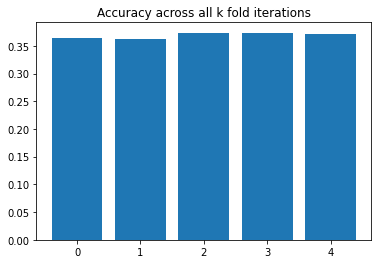

In [27]:
plt.bar([x for x in range(len(accuracyArray))],accuracyArray)
plt.title("Accuracy across all k fold iterations")

### Smoothing Operation 

Laplace smoothing is a smoothing technique that helps tackle the problem of zero probability in the Naïve Bayes machine learning algorithm

It modififies the computation of probabilities by making the following change to the formula 


$P(word| category) =  \frac{Num of Occurances of word in that category  + \alpha}{N*\alpha + numOf Occurences of word in total}$

Here $\alpha$ is the smoothing parameter, which is generally taken as 1 

In [30]:
from sklearn.metrics import accuracy_score, f1_score , precision_score
import re
def crossValidationNaiveBayesWithSmoothing(count,train,kfold,PropConst,alpha):
    accuracyArray = []
    f1Array = []
    precisionArray = []
    for iterNum in range(kfold):
        print("Performing Cross Validation : " , iterNum)
        train_kfold, dev_kfold = \
                  np.split(train.sample(frac=1, random_state=np.random.randint(0,100)), 
                           [int(.8*len(train))])
        
        count = train_kfold['category'].value_counts()
        priorProbability = {key: value for key, value in count.items()}
        for k,v in count.items():
            priorProbability[k] = v/train_kfold.shape[0];
        
        wordList = []
        

        mainDictionary = {}
        for category,value in zip(train_kfold.category,train_kfold.headline):
            values = value.split(' ')
            values = list(map(str.lower,values))

            for k in values:
                ## Existing Values
                k = str(k)
                k_new = re.sub('[^a-zA-Z0-9 \n\.]', '', k)
                if( k_new not in mainDictionary ):
                    mainDictionary[k_new] = {key: 0 for key, value in count.items()}

                mainDictionary[k_new][category] +=1;
                
        freqWords = pd.DataFrame(mainDictionary)
        avoidList = ['the', 'to', 'a','of','in','and','for','is','on','your','with','my','you','at','as','this','why','how','what','who','i','are','that']
        freqWords = freqWords.drop(avoidList,axis=1)
        freqWords += alpha;
        ConditionalProb = freqWords.copy(deep=True)
        
        
        ConditionalProb = ConditionalProb.div(ConditionalProb.sum(axis=1) + len(PREDICTIONLABEL)*alpha, axis=0)
        
        yActual = dev_kfold.category.to_list()

        Y_test = []
        for line in dev_kfold.headline.to_list():
            lines = line.split(' ')
            values = list(map(str.lower,lines))
            newlist = [];
            for k in values:
                k = str(k);
                k_new = re.sub('[^a-zA-Z0-9 \n\.]', '', k)
                if(k_new not in avoidList):
                    newlist.append(k_new)

            Y_test.append(newlist)
        
        Y_pred = []
        
        for data in Y_test:
            probList = []
            for cat in PREDICTIONLABEL:
                probList.append(priorProbability[cat]*PropConst)
            probList = np.array(probList);
            for word in data:
                try:
                    probList *= ConditionalProb[word].to_numpy()
                except KeyError:
                    probList *= np.ones_like(ConditionalProb.iloc[:,0])*(alpha/len(PREDICTIONLABEL));
            Y_pred.append(probList)
        
        Y_pred_df = pd.DataFrame(Y_pred)

        prevSize = Y_pred_df.shape[0];
#         print("Actual Size : " , prevSize)
        ##Remvove the entries with zero probability , to compute accuracy
        Y_pred_df["idmax"] = Y_pred_df.idxmax(axis=1)
        Y_pred_df["sum"] = Y_pred_df.sum(axis=1)


        yPred_num = [];
        yActual_num = [];
        for i in range(len(yActual)):
        #     if(Y_pred_df["sum"][i] > 0):
            yActual_num.append(PREDICTIONLABEL_DICT[yActual[i]] )
            yPred_num.append(Y_pred_df["idmax"][i])

        accuracyArray.append(accuracy_score(yActual_num,yPred_num))
#         precisionArray.append(precision_score(yActual_num,yPred_num,average='macro'))
#         f1Array.append( f1_score(yActual_num,yPred_num,average='micro'))
        
        print("     Accuracy  : " , accuracyArray[iterNum])
#         print("     Precision : " , precisionArray[iterNum])
#         print("     F1        : " , f1Array[iterNum])
    
    return sum(accuracyArray)/len(accuracyArray)
    

## Comparision of the Solution between Smoothing and Non Smoothed NVB

Here we will compare the accuracy of the solution between the NBC with and without smoothing 

In [31]:
results = {}
results['no Smoothing'] = crossValidationNaiveBayesWithSmoothing(count,train,5,10,0)
results['0.8'] = crossValidationNaiveBayesWithSmoothing(count,train,5,10,0.8)
results['1'] = crossValidationNaiveBayesWithSmoothing(count,train,5,10,1)
results['2'] = crossValidationNaiveBayesWithSmoothing(count,train,5,10,2)
results['5'] = crossValidationNaiveBayesWithSmoothing(count,train,5,10,5)
results['10'] = crossValidationNaiveBayesWithSmoothing(count,train,5,10,10)

Performing Cross Validation :  0
     Accuracy  :  0.33610202198170985
Performing Cross Validation :  1
     Accuracy  :  0.3183572447352966
Performing Cross Validation :  2
     Accuracy  :  0.34231059652655427
Performing Cross Validation :  3
     Accuracy  :  0.3442822384428224
Performing Cross Validation :  4
     Accuracy  :  0.32620186257236344
Performing Cross Validation :  0
     Accuracy  :  0.4333836731269402
Performing Cross Validation :  1
     Accuracy  :  0.46165785720278546
Performing Cross Validation :  2
     Accuracy  :  0.4539810386777414
Performing Cross Validation :  3
     Accuracy  :  0.47734709287691923
Performing Cross Validation :  4
     Accuracy  :  0.4884637972984311
Performing Cross Validation :  0
     Accuracy  :  0.4694605252118466
Performing Cross Validation :  1
     Accuracy  :  0.4503314036412451
Performing Cross Validation :  2
     Accuracy  :  0.45016360432922226
Performing Cross Validation :  3
     Accuracy  :  0.4732779595603658
Performing Cro

Text(0.5, 1.0, 'Accuracy with/without Smoothing ')

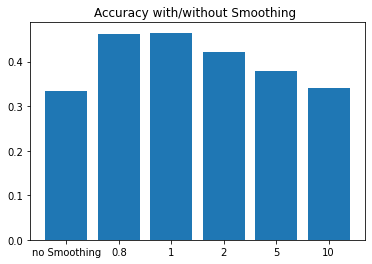

In [34]:
plt.bar(*zip(*results.items()))
plt.title("Accuracy with/without Smoothing ")

## Accuracy on the Testing Data 

Now we will test the accuracy on the testing data 



In [40]:
def crossValidationNaiveBayesWithSmoothing_test(count,train,PropConst,alpha):
    train_kfold =  train
    count = train_kfold['category'].value_counts()
    priorProbability = {key: value for key, value in count.items()}
    for k,v in count.items():
        priorProbability[k] = v/train_kfold.shape[0];

    wordList = []


    mainDictionary = {}
    for category,value in zip(train_kfold.category,train_kfold.headline):
        values = value.split(' ')
        values = list(map(str.lower,values))

        for k in values:
            ## Existing Values
            k = str(k)
            k_new = re.sub('[^a-zA-Z0-9 \n\.]', '', k)
            if( k_new not in mainDictionary ):
                mainDictionary[k_new] = {key: 0 for key, value in count.items()}

            mainDictionary[k_new][category] +=1;

    freqWords = pd.DataFrame(mainDictionary)
    avoidList = ['the', 'to', 'a','of','in','and','for','is','on','your','with','my','you','at','as','this','why','how','what','who','i','are','that']
    freqWords = freqWords.drop(avoidList,axis=1)
    freqWords += alpha;
    ConditionalProb = freqWords.copy(deep=True)


    ConditionalProb = ConditionalProb.div(ConditionalProb.sum(axis=1) + len(PREDICTIONLABEL)*alpha, axis=0)

    yActual = dev_kfold.category.to_list()

    Y_test = []
    for line in dev_kfold.headline.to_list():
        lines = line.split(' ')
        values = list(map(str.lower,lines))
        newlist = [];
        for k in values:
            k = str(k);
            k_new = re.sub('[^a-zA-Z0-9 \n\.]', '', k)
            if(k_new not in avoidList):
                newlist.append(k_new)

        Y_test.append(newlist)

    Y_pred = []
    
    for data in Y_test:
        probList = []
        for cat in PREDICTIONLABEL:
            probList.append(priorProbability[cat]*PropConst)
        probList = np.array(probList);
        for word in data:
            try:
                probList *= ConditionalProb[word].to_numpy()
            except KeyError:
                probList *= np.ones_like(ConditionalProb.iloc[:,0])*(alpha/len(PREDICTIONLABEL));
        Y_pred.append(probList)

    Y_pred_df = pd.DataFrame(Y_pred)

    prevSize = Y_pred_df.shape[0];
#         print("Actual Size : " , prevSize)
    ##Remvove the entries with zero probability , to compute accuracy
    Y_pred_df["idmax"] = Y_pred_df.idxmax(axis=1)
    Y_pred_df["sum"] = Y_pred_df.sum(axis=1)


    yPred_num = [];
    yActual_num = [];
    for i in range(len(yActual)):
    #     if(Y_pred_df["sum"][i] > 0):
        yActual_num.append(PREDICTIONLABEL_DICT[yActual[i]] )
        yPred_num.append(Y_pred_df["idmax"][i])


    print("     Accuracy  : " ,accuracy_score(yActual_num,yPred_num))
#         print("     Precision : " , precisionArray[iterNum])
#         print("     F1        : " , f1Array[iterNum])

    return accuracy_score(yActual_num,yPred_num)

In [42]:
accuracy = crossValidationNaiveBayesWithSmoothing_test(count,Test,10,1)
print(" The final accuracy of our model is : " , accuracy*100 , " % ")

     Accuracy  :  0.4051514388791006
 The final accuracy of our model is :  40.51514388791006  % 


## Most common words in each category

In [53]:
wordList = []
import re

count = train['category'].value_counts()
mainDictionary = {}
for category,value in zip(df.category,df.headline):
    values = value.split(' ')
    values = list(map(str.lower,values))
    
    for k in values:
        ## Existing Values
        k = str(k)
        k_new = re.sub('[^a-zA-Z0-9 \n\.]', '', k)
        if( k_new not in mainDictionary ):
            mainDictionary[k_new] = {key: 0 for key, value in count.items()}
        
        mainDictionary[k_new][category] +=1;

freqWords = pd.DataFrame(mainDictionary)
avoidList = ['the', 'to', 'a','of','in','and','for','is','on','your','with','my','you','at','as',\
             'after','her','may','this','why','how','what','who','i','are','that','be','it','from','its','not','will','says','by','5','10','50']
freqWords = freqWords.drop(avoidList,axis=1)
freqWords += 1;
ConditionalProb = freqWords.copy(deep=True)


ConditionalProb = ConditionalProb.div(ConditionalProb.sum(axis=1) + len(PREDICTIONLABEL)*1, axis=0)
nlargest = 10
order = np.argsort(-ConditionalProb.values, axis=1)[:, :nlargest]
result = pd.DataFrame(ConditionalProb.columns[order], 
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=ConditionalProb.index)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [54]:
result

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
POLITICS,trump,donald,trumps,gop,clinton,about,his,hillary,new,house
WELLNESS,life,health,do,can,new,cancer,,we,day,about
ENTERTAINMENT,new,about,trump,his,star,first,out,donald,,up
TRAVEL,photos,travel,best,new,world,hotels,most,,hotel,video
STYLE & BEAUTY,photos,fashion,style,,week,more,photo,video,new,beauty
PARENTING,kids,parents,about,children,mom,baby,parenting,child,day,when
HEALTHY LIVING,health,about,can,life,more,ways,when,people,new,cancer
QUEER VOICES,gay,new,queer,about,trans,lgbtq,out,lgbt,marriage,transgender
FOOD & DRINK,recipes,best,food,make,photos,,recipe,new,day,video
BUSINESS,business,women,new,,about,wall,can,more,ceo,an


# References
- https://en.wikipedia.org/wiki/Cross-validation_(statistics)
- https://en.wikipedia.org/wiki/Naive_Bayes_classifier
- https://towardsdatascience.com/introduction-to-na%C3%AFve-bayes-classifier-fa59e3e24aaf
- https://towardsdatascience.com/introduction-to-na%C3%AFve-bayes-classifier-fa59e3e24aaf